<a href="https://colab.research.google.com/github/vadhri/ai-notebook/blob/main/timeseries/forecasting_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates how to perform time series forecasting on daily sales data using various exponential smoothing and ARIMA models.

The data is loaded from a Kaggle dataset, preprocessed to aggregate daily sales per SKU and region, and then used to train and forecast future sales for the top performing pairs of SKU and region.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("beatafaron/fmcg-daily-sales-data-to-2022-2024")

print("Path to dataset files:", path)

100%|██████████| 3.69M/3.69M [00:00<00:00, 107MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/beatafaron/fmcg-daily-sales-data-to-2022-2024/versions/16


In [3]:
!ls -lart  /kaggle/input/fmcg-daily-sales-data-to-2022-2024

ls: cannot access '/kaggle/input/fmcg-daily-sales-data-to-2022-2024': No such file or directory


In [4]:
!ls {path}
path += "/FMCG_2022_2024.csv"

batch_MI-006_2025-01-06.parquet  df_weekly_MI-006_enriched.csv
batch_MI-006_2025-01-13.parquet  FMCG_2022_2024.csv
batch_MI-006_2025-01-20.parquet  weekly_df_final_for_modeling.csv
batch_MI-006_2025-01-27.parquet


In [5]:
data_df = pd.read_csv(path, parse_dates=['date'], index_col='date')
data_df.head()

,sku,brand,segment,category,channel,region,pack_type,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
date,,,,,,,,,,,,,
2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-Central,Multipack,2.38,0,1,141,128,9
2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-North,Single,1.55,1,3,0,129,0
2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Retail,PL-South,Carton,4.00,0,5,118,161,8
2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-Central,Single,5.16,0,2,81,114,7
2022-01-21,MI-006,MiBrand1,Milk-Seg3,Milk,Discount,PL-North,Single,7.66,0,4,148,204,12


In [9]:
# Forecast per SKU + Region
group_cols = ["sku", "region"]

daily_sales = (
    data_df.groupby(group_cols + [pd.Grouper(freq="D")])["units_sold"]
      .sum()
      .reset_index()
)

# Pivot so each (sku, region) becomes a column
sales_pivot = daily_sales.pivot(index="date", columns=group_cols, values="units_sold").fillna(0)
sales_pivot.head()


sku            JU-021                       MI-002                    \
region     PL-Central PL-North PL-South PL-Central PL-North PL-South   
date                                                                   
2022-01-21        0.0      0.0      0.0        0.0      0.0      0.0   
2022-01-22        0.0      0.0      0.0        0.0      0.0      0.0   
2022-01-23        0.0      0.0      0.0        0.0      0.0      0.0   
2022-01-24        0.0      0.0      0.0        0.0      0.0      0.0   
2022-01-25        0.0      0.0      0.0        0.0      0.0      0.0   

sku            MI-006                       MI-008  ...   YO-018     YO-020  \
region     PL-Central PL-North PL-South PL-Central  ... PL-South PL-Central   
date                                                ...                       
2022-01-21       16.0     19.0     50.0        0.0  ...      0.0        0.0   
2022-01-22       63.0     17.0     39.0        0.0  ...      0.0        0.0   
2022-01-23       35.0     30.0     57.0        0.0  ...      0.0        0.0   
2022-01-24       23.0     31.0     22.0        0.0  ...      0.0        0.0   
2022-01-25       35.0     23.0     18.0        0.0  ...      0.0        0.0   

sku                              YO-024                       YO-029           \
region     PL-North PL-South PL-Central PL-North PL-South PL-Central PL-North   
date                                                                            
2022-01-21      0.0      0.0        0.0      0.0      0.0        0.0      0.0   
2022-01-22      0.0      0.0        0.0      0.0      0.0        0.0      0.0   
2022-01-23      0.0      0.0        0.0      0.0      0.0        0.0      0.0   
2022-01-24      0.0      0.0        0.0      0.0      0.0        0.0      0.0   
2022-01-25      0.0      0.0        0.0      0.0      0.0        0.0      0.0   

sku                  
region     PL-South  
date                 
2022-01-21      0.0  
2022-01-22      0.0  
2022-01-23      0.0  
2022-01-24      0.0  
2022-01-25      0.0  

[5 rows x 90 columns]

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


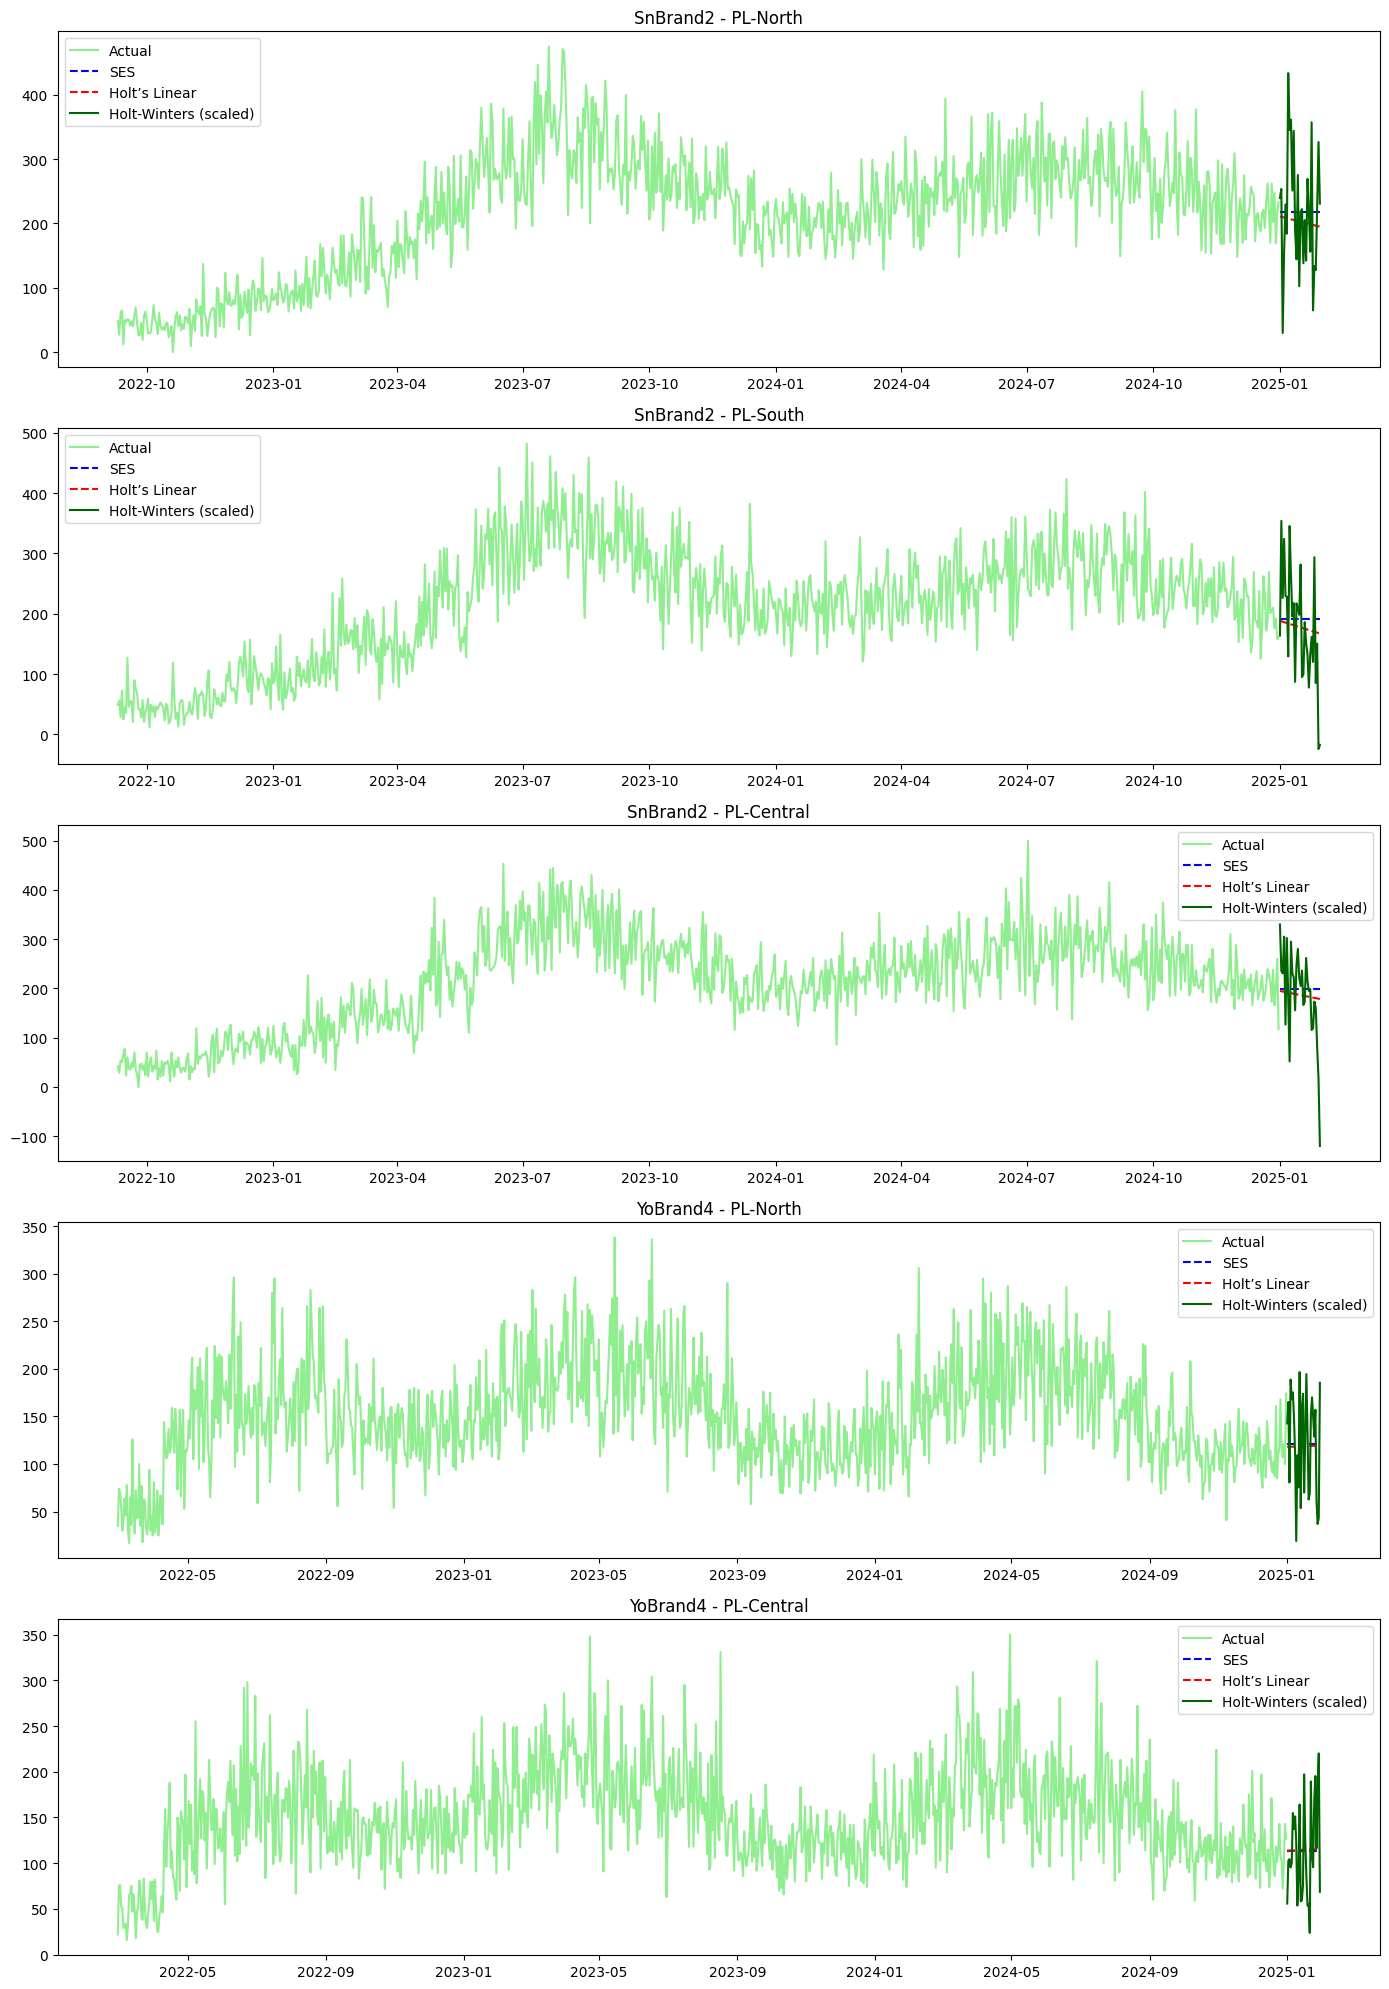

In [31]:
# Pick 5 (brand, region) pairs with highest total sales
top_pairs = data_df.groupby(["brand", "region"])["units_sold"].sum().sort_values(ascending=False).head(5).index

fig, axes = plt.subplots(len(top_pairs), 1, figsize=(14, 20))

for i, (brand, region) in enumerate(top_pairs):
    # Subset and aggregate daily
    sub = data_df[(data_df["brand"] == brand) & (data_df["region"] == region)]
    series = sub["units_sold"].resample("D").sum()
    series = series.astype(float)

    # avoid zeros for multiplicative models
    series[series <= 0] = 1e-3

    # Skip if too short
    if len(series) < 10:
        continue

    # 1. Simple Exponential Smoothing (SES)
    ses_model = SimpleExpSmoothing(series).fit()
    ses_forecast = ses_model.forecast(30)

    # 2. Holt’s Linear Trend
    holt_model = ExponentialSmoothing(series, trend="add", seasonal=None).fit()
    holt_forecast = holt_model.forecast(30)

    # 3. Holt-Winters (weekly seasonality, multiplicative)
    hw_model = ExponentialSmoothing(series, trend="add", seasonal="mul", seasonal_periods=30).fit()
    hw_forecast = hw_model.forecast(30)

    # ---- Variance scaling around mean ----
    hist_std = series.std()
    fcast_std = hw_forecast.std()

    if fcast_std > 0:
        scale_factor = hist_std / fcast_std
    else:
        scale_factor = 1.0

    # Center → scale swings → restore mean
    hw_forecast_scaled = (hw_forecast - hw_forecast.mean()) * scale_factor + hw_forecast.mean()

    # Plot actual + forecasts
    axes[i].plot(series.index, series.values, label="Actual", color="lightgreen")
    axes[i].plot(ses_forecast.index, ses_forecast.values, label="SES", color="blue", linestyle="--")
    axes[i].plot(holt_forecast.index, holt_forecast.values, label="Holt’s Linear", color="red", linestyle="--")
    axes[i].plot(hw_forecast_scaled.index, hw_forecast_scaled.values, label="Holt-Winters (scaled)", color="darkgreen", linestyle="-")

    axes[i].set_title(f"{brand} - {region}")
    axes[i].legend()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/pyth

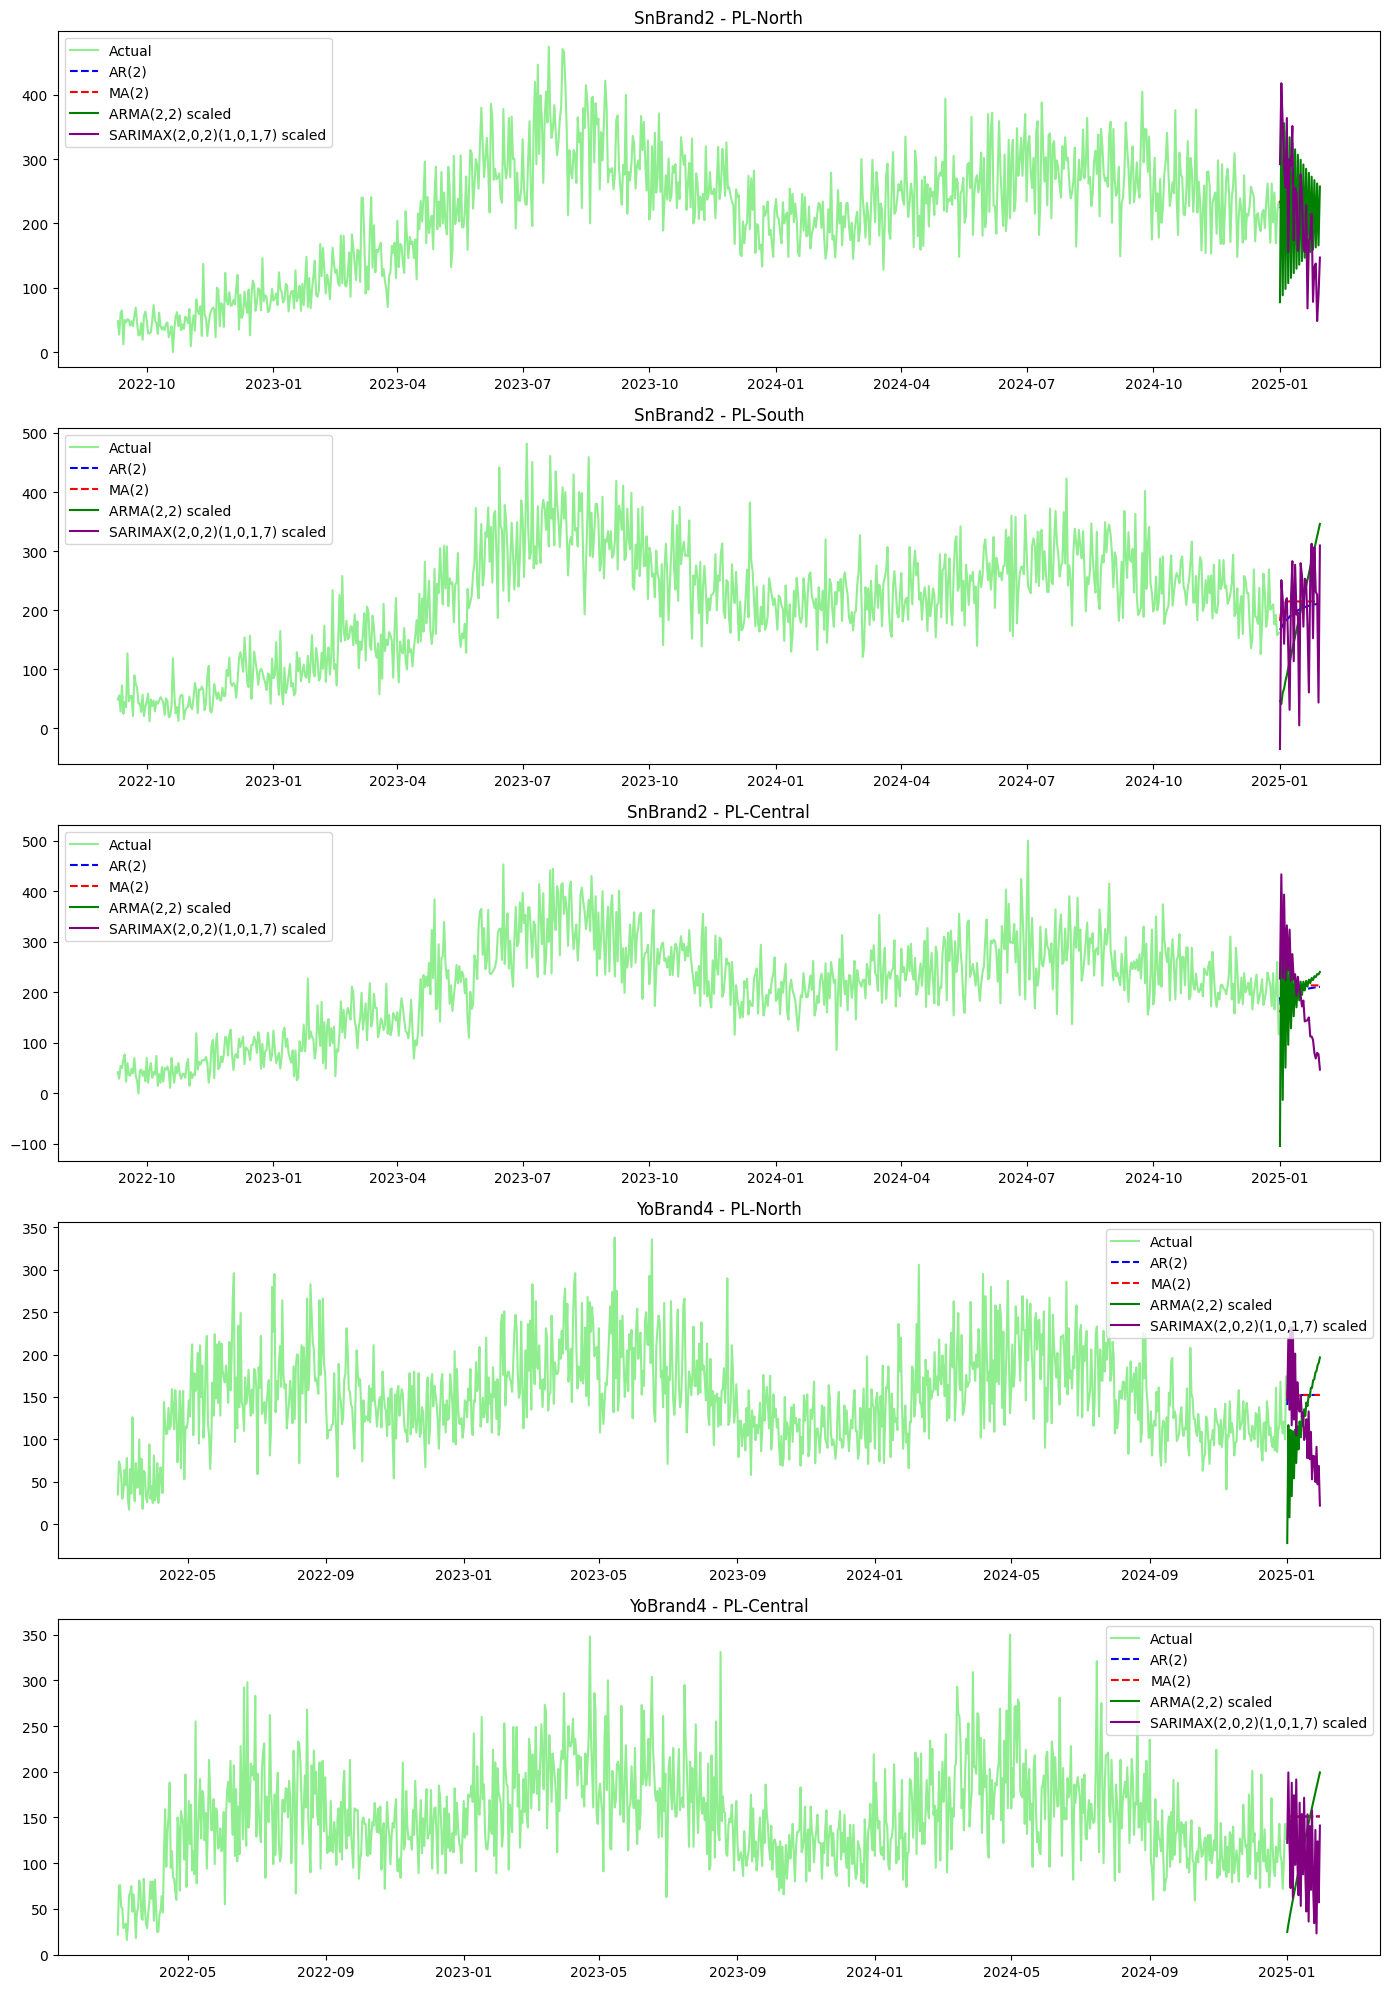

In [46]:
# Pick 5 (brand, region) pairs with highest total sales
top_pairs = data_df.groupby(["brand", "region"])["units_sold"].sum().sort_values(ascending=False).head(5).index

fig, axes = plt.subplots(len(top_pairs), 1, figsize=(14, 20))

for i, (brand, region) in enumerate(top_pairs):
    # Subset and aggregate daily
    sub = data_df[(data_df["brand"] == brand) & (data_df["region"] == region)]
    series = sub["units_sold"].resample("D").sum().astype(float)  # ensure float

    if len(series) < 15:  # need sufficient points
        continue

    # 1. AR model (p=2)
    ar_model = ARIMA(series, order=(2,0,0)).fit()
    ar_forecast = ar_model.forecast(30)

    # 2. MA model (q=2)
    ma_model = ARIMA(series, order=(0,0,2)).fit()
    ma_forecast = ma_model.forecast(30)

    # 3. ARMA model (p=2, q=2)
    arma_model = ARIMA(series, order=(2,0,2)).fit()
    arma_forecast = arma_model.forecast(30)

    # 4. SARIMAX model with weekly seasonality (s=7)
    sarimax_model = SARIMAX(series, order=(2,0,2), seasonal_order=(1,0,1,7), enforce_stationarity=True, enforce_invertibility=True).fit(disp=False)
    sarimax_forecast = sarimax_model.get_forecast(30).predicted_mean

    # Variance scaling for ARMA and SARIMAX
    hist_std = series.std()

    # ARMA scaling
    fcast_std = arma_forecast.std()
    scale_factor = hist_std / fcast_std if fcast_std > 0 else 1.0
    arma_forecast_scaled = (arma_forecast - arma_forecast.mean()) * scale_factor + arma_forecast.mean()

    # SARIMAX scaling
    fcast_std = sarimax_forecast.std()
    scale_factor = hist_std / fcast_std if fcast_std > 0 else 1.0
    sarimax_forecast_scaled = (sarimax_forecast - sarimax_forecast.mean()) * scale_factor + sarimax_forecast.mean()

    # Plot actual + forecasts
    axes[i].plot(series.index, series.values, label="Actual", color="lightgreen")
    axes[i].plot(ar_forecast.index, ar_forecast.values, label="AR(2)", color="blue", linestyle="--")
    axes[i].plot(ma_forecast.index, ma_forecast.values, label="MA(2)", color="red", linestyle="--")
    axes[i].plot(arma_forecast_scaled.index, arma_forecast_scaled.values, label="ARMA(2,2) scaled", color="green", linestyle="-")
    axes[i].plot(sarimax_forecast_scaled.index, sarimax_forecast_scaled.values, label="SARIMAX(2,0,2)(1,0,1,7) scaled", color="purple", linestyle="-")

    axes[i].set_title(f"{brand} - {region}")
    axes[i].legend()

plt.tight_layout()
plt.show()
